base on https://github.com/Halip26/face-to-blur

caffeModel https://github.com/GeekLiB/caffe-model

In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=230ae49771b5db3e8c8c0fd36dd0ccd2e0b9580738dc75c2570b31d2bc02c952
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from deepface import DeepFace

25-03-10 00:48:22 - Directory /root/.deepface has been created
25-03-10 00:48:22 - Directory /root/.deepface/weights has been created


In [ ]:
def load_model():
    """Carga el modelo de detección de rostros."""
    # https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
    prototxt_path = "weights/deploy.prototxt.txt"
    # https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel
    model_path = "weights/res10_300x300_ssd_iter_140000_fp16.caffemodel"
    return cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

# Cargar modelo de estimación de edad
prototxt_age_path = "weights/age_deploy.prototxt"
model_age_path = "weights/age_net.caffemodel"
age_net = cv2.dnn.readNetFromCaffe(prototxt_age_path, model_age_path)
age_ranges = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']

In [ ]:
def detect_faces(image, model):
    """Detecta rostros en la imagen usando OpenCV DNN."""
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    model.setInput(blob)
    detections = model.forward()
    return [(d[2], (d[3:7] * np.array([width, height, width, height])).astype(int)) for d in detections[0, 0] if d[2] > 0.4]

def estimate_age(face_img):
    """Analiza la edad del rostro usando el modelo de edad."""
    blob = cv2.dnn.blobFromImage(face_img, scalefactor=1.4, size=(227, 227), mean=(80, 90, 110), swapRB=False, crop=False)
    age_net.setInput(blob)
    predictions = age_net.forward()
    age_index = predictions[0].argmax()
    return age_ranges[age_index]

def apply_blur(face):
    """Aplica un desenfoque gaussiano en el rostro."""
    kernel_size = (face.shape[1] // 7 | 1, face.shape[0] // 7 | 1)
    return cv2.GaussianBlur(face, kernel_size, 0)

def process_images(input_dir, output_dir, model):
    """Procesa todas las imágenes en el directorio de entrada."""
    os.makedirs(output_dir, exist_ok=True)

    for image_path in glob(os.path.join(input_dir, "*.jpg")):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: No se pudo cargar {image_path}")
            continue

        for confidence, (start_x, start_y, end_x, end_y) in detect_faces(image, model):
            face = image[start_y:end_y, start_x:end_x]
            if face.size == 0:
                continue
            age = estimate_age(face)
            age_number = int(age.strip('()').split('-')[0])  # Obtener edad aproximada
            if age_number < 18:
                face = apply_blur(face)
            image[start_y:end_y, start_x:end_x] = face
            cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
            cv2.putText(image, age, (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        output_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(output_path, image)
        print(f"Procesado: {output_path}")

In [ ]:
def show_images(directory):
    """Muestra las imágenes procesadas."""
    for filename in filter(lambda f: f.endswith(('.jpg', '.jpeg', '.png')), os.listdir(directory)):
        image_path = os.path.join(directory, filename)
        img = plt.imread(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(filename)
        plt.axis('off')
        plt.show()

Procesado: output/prueba8.jpg
Procesado: output/prueba2.jpg
Procesado: output/prueba.jpg
Procesado: output/prueba4.jpg
Procesado: output/prueba6.jpg
Procesado: output/prueba5.jpg
Procesado: output/prueba7.jpg


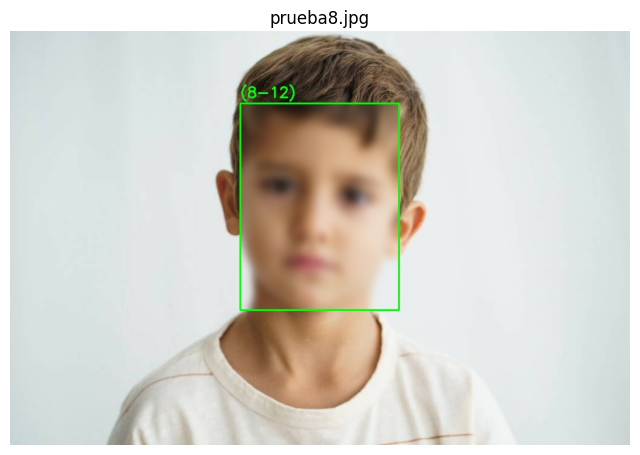

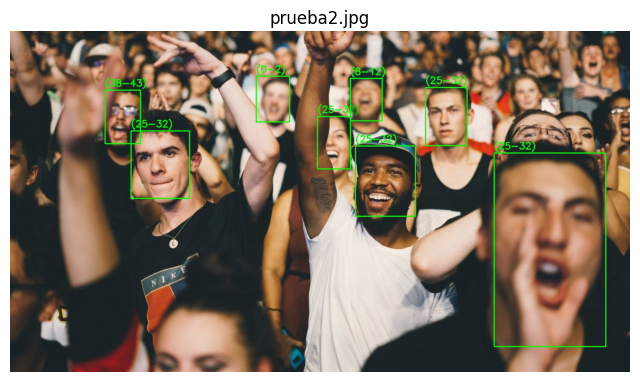

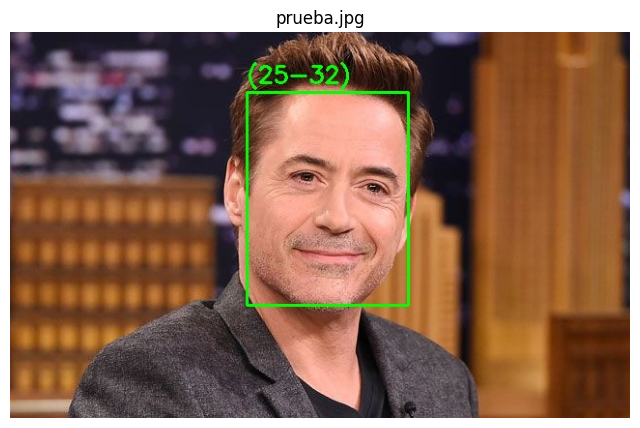

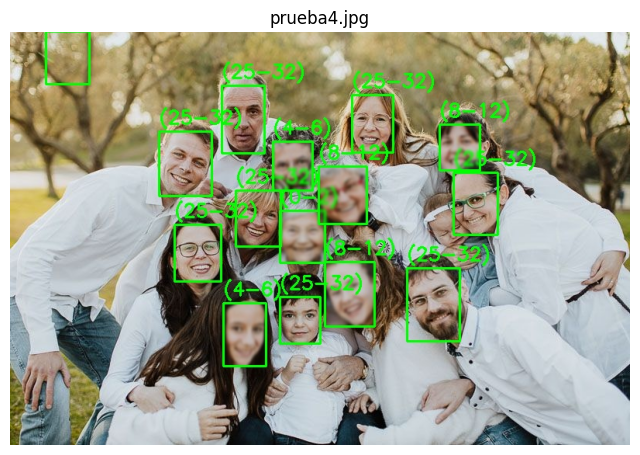

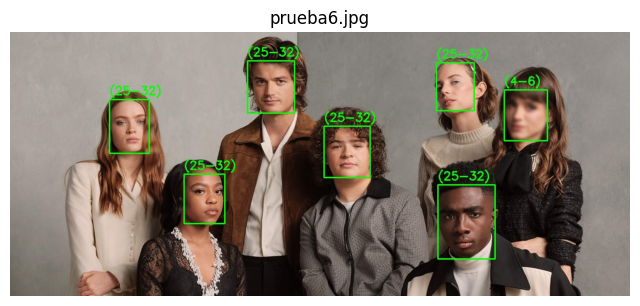

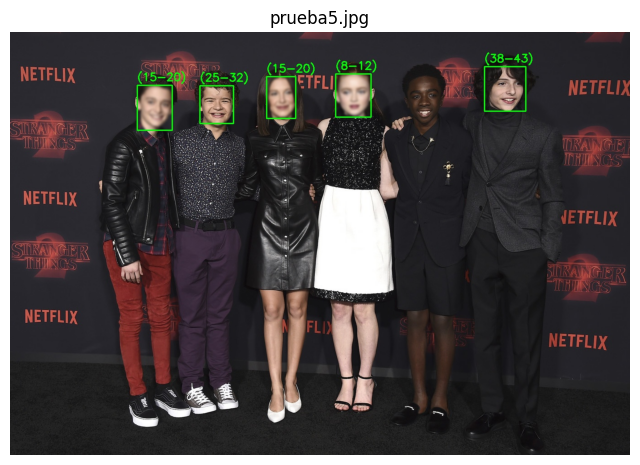

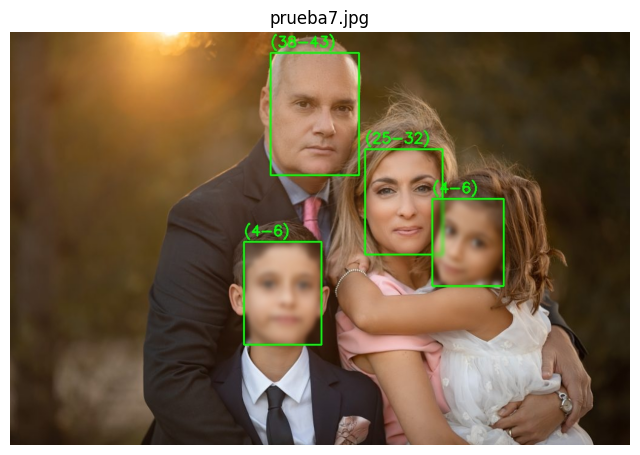

In [ ]:
    input_directory = "input/"
    output_directory = "output/"
    model = load_model()
    process_images(input_directory, output_directory, model)
    show_images(output_directory)